In [1]:
import matplotlib.pyplot as plt
from matplotlib import image
import numpy as np
from pathlib import Path
import tensorflow as tf
import os
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.models import Model, load_model

### Готовим данные для обучения

Устанавливаем пути для каталогов с изображениями

In [2]:
masked_files_path = r'./SyntheticMasks/'
clean_files_path = r'./SyntheticTrain/'

Создаем функции для формирования наборов исходных и целевых изображений. 

In [3]:
def get_samples(clean_path, masked_path, start=0, stop=-1):
    clean_files = [f.name for f in Path(clean_path).glob('*') if f.is_file()]
    masked_files = [f.name for f in Path(masked_path).glob('*') if f.is_file()]
    files = [file for file in clean_files if file in masked_files]
    if (stop == -1 or stop > len(files)):
        stop = len(files)
    files = files[start:stop]
    X = []
    y = []
    for file in files:
        clean_file = np.round(image.imread(f'{clean_path}{file}'))
        masked_file = np.round(image.imread(f'{masked_path}{file}'))

        X.append(clean_file)
        y.append(masked_file)
        
    return np.array(X), np.array(y)

### Сверточный автоэнкодер

https://neurohive.io/ru/osnovy-data-science/avtojenkoder-tipy-arhitektur-i-primenenie/

Автоэнкодеры сжимают входные данные для представления их в latent-space (скрытое пространство), а затем восстанавливают из этого представления output (выходные данные). Цель — получить на выходном слое отклик, наиболее близкий к входному.  
Автоэнкодеры могут применяться для избавления изображения от шума. В нашем случае, с использовааанием модели не избавляемся от лишних данных, а добавляем недостающие.  

Что касается модели, выбраны 3 сверточных слоя для кодера (32, 24, 8) с 2-мя слоями снижения размерности (max pooling).
Слои декодера располагаются в обратном порядке (8, 24, 32) и между ними два слоя повышения размерности (upsampling). Число нейронов подобрано эмпирически, путем многократных опытов, при этом выбиралось такое минимальное количество нейронов, чтобы сеть можно было относительно быстро обучить и не допустить переобучения.

In [4]:
def create_deep_conv_ae_colour(l1=32, l2=24, l3=8):
    input_img = Input(shape=(32, 32, 3))

    x = Conv2D(l1, (8, 8), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(l2, (2, 2), activation='relu', padding='same')(x)
    x = Conv2D(l3, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(3, (8, 8), activation='relu', padding='same')(x)

    # На этом моменте представление  (8, 8, 3) т.е. 3*64-размерное

    input_encoded = Input(shape=(8, 8, 3))
    x = Conv2D(l3, (8, 8), activation='relu', padding='same')(input_encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(l2, (2, 2), activation='relu', padding='same')(x)
    x = Conv2D(l1, (2, 2), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (8, 8), activation='sigmoid', padding='same')(x)

    # Модели
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

Создаем 3 набора данных для обучения (12000 экземпляров, на них сетка будет учиться), проверки(2000 экземпляров, их сетка смотрит для вычисления ошибок) и валидации (1000 ручная проверка).

In [5]:
X_train, y_train = get_samples(clean_files_path, masked_files_path, 0, 40000)
X_test, y_test = get_samples(clean_files_path, masked_files_path, 40001, 49000)
X_val, y_val = get_samples(clean_files_path, masked_files_path, 49001, 50000)

Создаем экземпляр сети. В качестве оптимизатора используем алгоритм адаптивной оценки момента (Adam) (https://arxiv.org/pdf/1412.6980.pdf) и в качестве функции потерь binary crossentropy (пока хз почему, но она показывает лучшие результаты), метрика - mse (но можно поставить любую другую, тут тоже пока есть вопросы)

In [6]:
l1, l2, l3 = 96, 48, 12

In [30]:
_, _, c_autoencoder = create_deep_conv_ae_colour(l1, l2, l3)
c_autoencoder.compile(optimizer='adam', loss='mse', metrics = ['logcosh', 'acc'])


#### Загрузка ранее обученной модели 
Можно загрузить уже обученную модель и не тратить время на обучение. Для этого нужно расскоментировать и выполнить следующую ячейку.

In [11]:
c_autoencoder = tf.keras.models.load_model('model_cl_96-48-12.md')

### Если мы загрузили модель из ячейки выше, то нижележащую ячейку выполнять не надо!

Здесь модель обучается заново, для этого строки надо раскомментировать.

In [31]:
history = c_autoencoder.fit(X_train, y_train,
                  epochs=100,
                  batch_size=50,
                  shuffle=True,
                  validation_data=(X_test, y_test))

Epoch 1/100
240/240 [==============================] - 8s 29ms/step - loss: 0.0733 - logcosh: 0.0343 - acc: 0.8048 - val_loss: 0.0377 - val_logcosh: 0.0175 - val_acc: 0.7986
Epoch 2/100
240/240 [==============================] - 7s 29ms/step - loss: 0.0323 - logcosh: 0.0150 - acc: 0.8085 - val_loss: 0.0284 - val_logcosh: 0.0131 - val_acc: 0.8281
Epoch 3/100
240/240 [==============================] - 7s 29ms/step - loss: 0.0258 - logcosh: 0.0119 - acc: 0.8407 - val_loss: 0.0234 - val_logcosh: 0.0108 - val_acc: 0.8284
Epoch 4/100
240/240 [==============================] - 7s 29ms/step - loss: 0.0226 - logcosh: 0.0104 - acc: 0.8653 - val_loss: 0.0216 - val_logcosh: 0.0100 - val_acc: 0.8622
Epoch 5/100
240/240 [==============================] - 7s 29ms/step - loss: 0.0204 - logcosh: 0.0094 - acc: 0.8801 - val_loss: 0.0192 - val_logcosh: 0.0089 - val_acc: 0.8773
Epoch 6/100
240/240 [==============================] - 7s 29ms/step - loss: 0.0187 - logcosh: 0.0086 - acc: 0.8866 - val_loss: 0.0

Сохраняем обученную модель.

In [35]:
c_autoencoder.save(f'model_cl_{l1}-{l2}-{l3}.md')

INFO:tensorflow:Assets written to: model_cl_96-48-12.md\assets


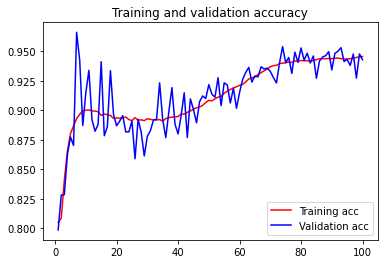

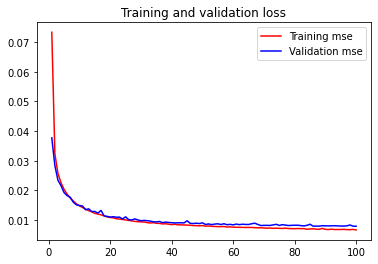

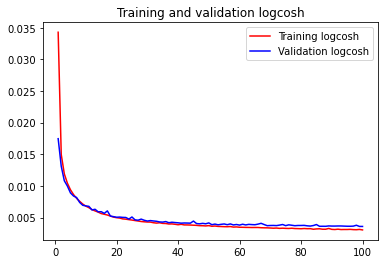

In [43]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

logcosh = history.history['logcosh']
val_logcosh = history.history['val_logcosh']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label='Training mse')
plt.plot(epochs, val_loss, 'b', label='Validation mse')
plt.title('Training and validation loss')
plt.legend()

plt.figure()
plt.plot(epochs, logcosh, 'r', label='Training logcosh')
plt.plot(epochs, val_logcosh, 'b', label='Validation logcosh')
plt.title('Training and validation logcosh')
plt.legend()

plt.show()

### Оценка качества модели

Здесь мы работаем с блоком валидации X_val

Создаем функцию предсказания и постобработки изображения. На вход функции поступает модель(нейросеть), массив исходных изображений, позиция номер элемента в массиве. Функция запрашивает прогноз у модели для указанного элемената. Полученный результат обрабатывается следующим образом: 
- полученные красные пиксели накладываются только на белые участки исходного изображения;
- удаляются все точки кроме красных, черных и белых;
- удаляются отдельные красные точки, которые не соприкасаются с дргуими красными точками по вертикали или горизонтали.

In [36]:
def get_predicted_image(model, X ,n=0):
    def border_points(pr, i, j):
        if i-1 >= 0 and (pr[0][i-1][j] == [1.,0.,0.]).all():
            return True
        if j-1 >= 0 and (pr[0][i][j-1] == [1.,0.,0.]).all():
            return True
        if i+1 < pr.shape[1] and (pr[0][i+1][j] == [1.,0.,0.]).all():
            return True
        if j+1 < pr.shape[2] and (pr[0][i][j+1] == [1.,0.,0.]).all():
            return True
        return False
    X = X[n:n+1]
    pr = model.predict(X)
    pr = np.round(pr)

    for i in range(pr.shape[1]):
        for j in range(pr.shape[2]):
            if ((X[0][i][j] == [1.,1.,1.]).all() and (pr[0][i][j] == [1.,0.,0.]).all()) == False:
                pr[0][i][j] = X[0][i][j]
            
    for i in range(pr.shape[1]):
        for j in range(pr.shape[2]):
            if (pr[0][i][j] == [1.,0.,0.]).all() and border_points(pr, i, j) == False:
                pr[0][i][j] = [1.,1.,1.]
    return pr.reshape(32,32,3)

Вспомогательная функция для отрисовки картинок

In [37]:
def plot_image(position, data, title):
        plt.subplot (position)
        plt.imshow(data)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title (title)

Запускаем созданную нами функцию предсказания и постобработки. Смотрим что должно было быть и что получилось.

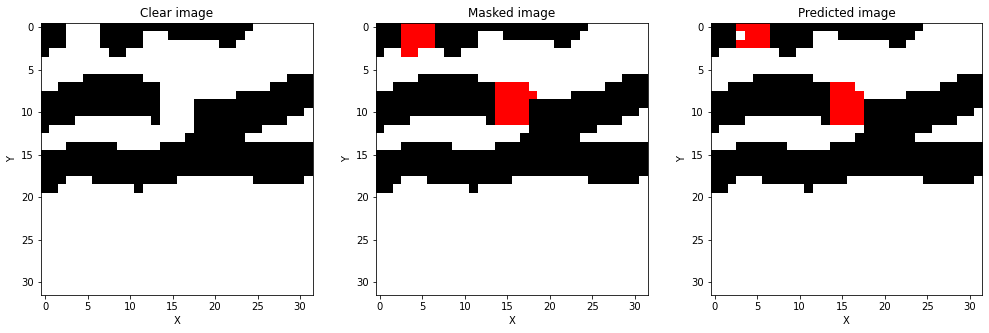

In [50]:
#nn = 546+6
# 441+6
nn=441+21

pr = get_predicted_image(c_autoencoder, X_val, nn)

plt.figure(figsize=(17, 5))
plot_image(131, X_val[nn:nn+1][0], "Clear image") 
plot_image(132, y_val[nn], "Masked image") 
plot_image(133, pr, "Predicted image") 

In [64]:
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances

numbers = list(range(len(X_val)))
dist=[]
         
for n in numbers:
    pr = get_predicted_image(c_autoencoder, X_val, n)
    dist.append(cosine_similarity(y_val[n].reshape(1,-1), pr.reshape(1,-1))[0][0])


Косинусное мера — это метрика поиска схожих объектов. Для сонаправленных векторов косинус угла будет равен единице, а для ортогональных векторов - нулю. То есть наши изображения одинаковы, значит их косинусная мера должна быть равна 1.

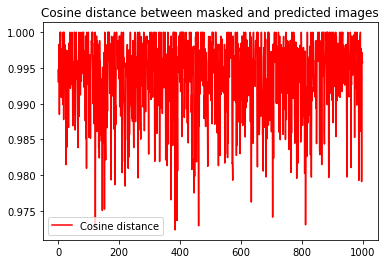

In [65]:
plt.plot(numbers, dist, 'r', label='Cosine distance')
plt.title('Cosine distance between masked and predicted images')
plt.legend()               
plt.show()

Посчитаем среднее значение косинусной меры для поверочного набора изображений. Также, вычислим среднее отклонение косинусной меры на проверочном наборе.

In [68]:
val_cosine_mean = np.mean(dist)
print(f'cosine similarity: {val_cosine_mean}')
print(f'cosine difference: {1-val_cosine_mean}')

cosine similarity: 0.9938096404075623
cosine difference: 0.006190359592437744


Видно, что мы попадаем очень близко.